In [1]:
!pip install numpy==1.23.5

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


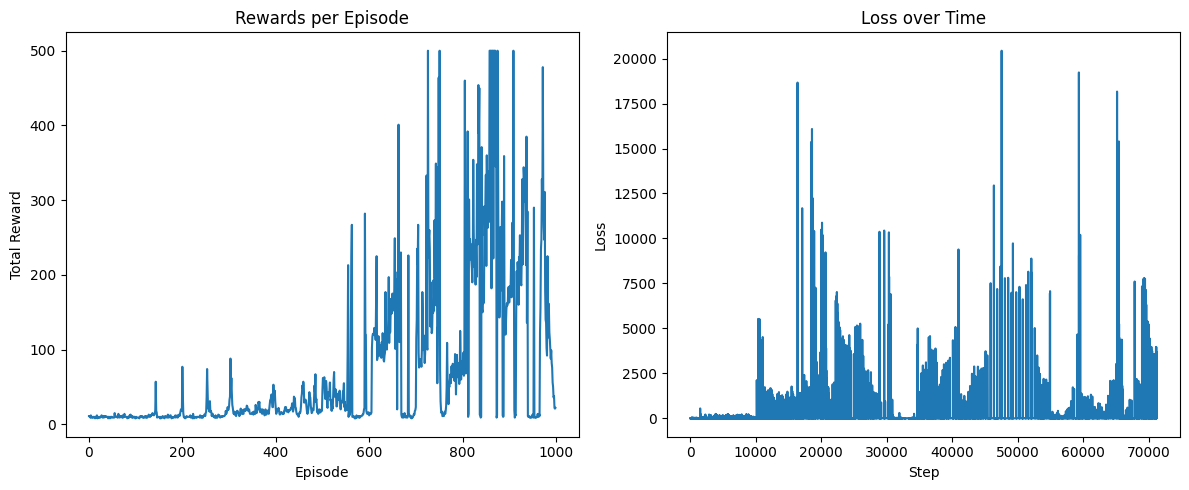

In [3]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Определяем нейронную сеть для Q-значений
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# SARSA алгоритм
def sarsa(env, num_episodes, alpha, gamma, epsilon):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_network = QNetwork(input_dim, output_dim)
    optimizer = optim.Adam(q_network.parameters(), lr=alpha)
    losses = []
    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()  # Исправление: распаковка кортежа
        done = False
        total_reward = 0

        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = torch.argmax(q_network(torch.FloatTensor(state))).item()

        while not done:
            next_state, reward, done, _ = env.step(action)  # Исправление: распаковка кортежа
            total_reward += reward

            # Epsilon-greedy action selection for the next state
            if np.random.rand() < epsilon:
                next_action = env.action_space.sample()
            else:
                with torch.no_grad():
                    next_action = torch.argmax(q_network(torch.FloatTensor(next_state))).item()

            # SARSA update
            target = reward + (gamma * q_network(torch.FloatTensor(next_state))[next_action].item() * (1 - int(done)))
            current_q_value = q_network(torch.FloatTensor(state))[action]
            loss = (target - current_q_value) ** 2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            action = next_action
            losses.append(loss.item())

        rewards_per_episode.append(total_reward)

    return rewards_per_episode, losses

# Основной код
if __name__ == "__main__":
    env = gym.make('CartPole-v1')  # Замените на 'Pong-v0' или другой Atari-игры
    num_episodes = 1000
    alpha = 0.001
    gamma = 0.99
    epsilon = 0.1

    rewards, losses = sarsa(env, num_episodes, alpha, gamma, epsilon)

    # Визуализация результатов
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Loss over Time')
    plt.xlabel('Step')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

    env.close()